# LLM-based Genetic Algorithm (Baseline)

This notebook implements an LLM-based GA as another baseline to compare against MATE.

**Key Characteristics:**
- **LLM-based population generation** - uses Gemini to create diverse initial paragraphs
- **LLM-based mutations** - uses Gemini with different prompts to perturb text
- **Simple elitism** - keeps top 3 individuals per generation
- **No saliency guidance** - mutations are random stylistic changes
- **No local search** - pure evolutionary approach
- **Smaller population** - 10 individuals (vs 20 in vanilla GA, 30 in MATE)

**Differences from MATE:**
- No saliency-guided mutations
- No Lagrangian constraint handling
- No local search/simulated annealing
- Simpler selection (top-k vs tournament)
- Fewer generations (5-10 vs 50)

**Differences from Vanilla GA:**
- Uses LLM instead of WordNet for mutations
- Better text quality (more natural)
- But still lacks gradient information and saliency

## Cell 1: Imports and Setup

In [14]:
# Cell 1: Imports and Setup
import os
import numpy as np
import torch
from pathlib import Path
from peft import PeftModel, PeftConfig
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import pandas as pd
import csv
from google import genai
from tqdm import tqdm
import time

# Setup directories
INPUT_FILE = Path("input.txt")
MODEL_PATH = Path("../task-2/transformer/tier_c_final_model")
LLM_GA_DIR = Path("llm-ga")  # LLM-based GA logs
LLM_GA_CSV = Path("llm_ga.csv")
LLM_GA_POPULATION_DIR = LLM_GA_DIR / "population"
LLM_GA_OFFSPRING_DIR = LLM_GA_DIR / "offspring"
LLM_GA_EVOLUTION_DIR = LLM_GA_DIR / "evolution"

# Create directories
LLM_GA_DIR.mkdir(exist_ok=True)
LLM_GA_POPULATION_DIR.mkdir(exist_ok=True)
LLM_GA_OFFSPRING_DIR.mkdir(exist_ok=True)
LLM_GA_EVOLUTION_DIR.mkdir(exist_ok=True)

print("Setup complete")
print(f"  Input: {INPUT_FILE}")
print(f"  Model: {MODEL_PATH}")
print(f"  Output: {LLM_GA_DIR}")
print(f"  Population: {LLM_GA_POPULATION_DIR}")
print(f"  Offspring: {LLM_GA_OFFSPRING_DIR}")
print(f"  Evolution: {LLM_GA_EVOLUTION_DIR}")

Setup complete
  Input: input.txt
  Model: ../task-2/transformer/tier_c_final_model
  Output: llm-ga
  Population: llm-ga/population
  Offspring: llm-ga/offspring
  Evolution: llm-ga/evolution


## Cell 2: Configure Gemini API

In [15]:
# Cell 2: Configure Gemini API
print("Configuring Gemini API...")

# Try to get API key from environment
api_key = os.getenv('GEMINI_API_KEY')

if not api_key:
    print("\n  GEMINI_API_KEY not found in environment!")
    print("\nPlease set your API key:")
    print("  export GEMINI_API_KEY='your-api-key-here'")
    print("\nOr enter it here (will be used for this session only):")
    api_key = input("Gemini API Key: ").strip()

if api_key:
    # Initialize client (matching mate.ipynb implementation)
    client = genai.Client(api_key=api_key)
    MODEL_NAME = "gemini-pro-latest"
    
    # Test API
    try:
        response = client.models.generate_content(
            model=MODEL_NAME,
            contents="Say 'API test successful'",
            config={
                "temperature": 0.7,
                "max_output_tokens": 8192,
            }
        )
        
        if response.candidates and response.candidates[0].content.parts:
            test_result = response.candidates[0].content.parts[0].text.strip()
            print(f"Gemini API configured successfully")
            print(f"  Model: {MODEL_NAME}")
            print(f"  Test response: {test_result}")
            gemini_model = True  # Flag to indicate API is working
        else:
            print(" API test failed: No response content")
            gemini_model = None
            client = None
    except Exception as e:
        print(f"✗ API test failed: {e}")
        gemini_model = None
        client = None
else:
    print("No API key provided")
    gemini_model = None
    client = None


Configuring Gemini API...
Gemini API configured successfully
  Model: gemini-pro-latest
  Test response: API test successful


## Cell 3: Load Classifier Model

In [16]:
# Cell 3: Load Classifier Model
print("Loading classifier model...")

# Load PEFT configuration
peft_model_id = str(MODEL_PATH)
config = PeftConfig.from_pretrained(peft_model_id)

# Load base model
base_model = AutoModelForSequenceClassification.from_pretrained(
    config.base_model_name_or_path,
    num_labels=3
)

tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
model = PeftModel.from_pretrained(base_model, peft_model_id)
model.eval()

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"Model loaded on {device}")
print(f"  Base: {config.base_model_name_or_path}")

Loading classifier model...


Loading weights: 100%|██████████| 100/100 [00:00<00:00, 886.38it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]   
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
classifier.bias         | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Model loaded on cpu
  Base: distilbert-base-uncased


## Cell 4: Load Semantic Similarity Model

In [17]:
# Cell 4: Load Semantic Similarity Model
print("Loading sentence transformer for semantic similarity...")

semantic_model = SentenceTransformer('all-MiniLM-L6-v2')

print("  Semantic model loaded")
print("  Model: all-MiniLM-L6-v2")

Loading sentence transformer for semantic similarity...


Loading weights: 100%|██████████| 103/103 [00:00<00:00, 866.97it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


  Semantic model loaded
  Model: all-MiniLM-L6-v2


## Cell 5: Helper Functions - Classifier & Semantic Similarity

In [18]:
# Cell 5: Helper Functions - Classifier & Semantic Similarity
def get_classifier_predictions(text):
    """Get classifier predictions for a text."""
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        logits = model(**inputs).logits
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()
    
    predicted_class = np.argmax(probs)
    confidence = probs[predicted_class]
    
    return probs, predicted_class, confidence

def get_human_probability(text):
    """Get P(Human) = P(Class 1) for a text."""
    probs, _, _ = get_classifier_predictions(text)
    return probs[0]

def get_semantic_similarity(text1, text2):
    """Compute cosine similarity between two texts."""
    embeddings = semantic_model.encode([text1, text2])
    similarity = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
    return similarity

# Test
test_text = "Technology has become an integral part of modern life."
probs, pred_class, conf = get_classifier_predictions(test_text)
print(f"Test prediction:")
print(f"  P(Human): {probs[0]:.4f}")
print(f"  P(AI): {probs[1]:.4f}")
print(f"  P(AI-mimicry): {probs[2]:.4f}")
print(f"  Predicted: Class {pred_class+1} (conf={conf:.4f})")

Test prediction:
  P(Human): 0.0025
  P(AI): 0.9951
  P(AI-mimicry): 0.0024
  Predicted: Class 2 (conf=0.9951)


## Cell 6: Fitness Function (Simple - P(Human) only)

In [19]:
# Cell 6: Fitness Function (Simple - P(Human) only)
def calculate_fitness(text, original_text):
    """
    LLM-GA Fitness Function: Simply P(Human).
    
    Unlike vanilla GA, we don't use hard constraints.
    We'll filter out texts with low similarity during selection instead.
    
    Args:
        text: Candidate text
        original_text: Original text for semantic comparison
    
    Returns:
        fitness: P(Human)
        components: Dict with breakdown
    """
    p_human = get_human_probability(text)
    similarity = get_semantic_similarity(text, original_text)
    
    components = {
        'fitness': p_human,
        'p_human': p_human,
        'similarity': similarity
    }
    
    return p_human, components

# Test
original = "Technology has become an integral part of modern life."
candidate = "Tech has become a key part of everyday life."

fitness, comp = calculate_fitness(candidate, original)
print(f"Fitness test:")
print(f"  Fitness: {fitness:.4f}")
print(f"  P(Human): {comp['p_human']:.4f}")
print(f"  Similarity: {comp['similarity']:.4f}")

Fitness test:
  Fitness: 0.0094
  P(Human): 0.0094
  Similarity: 0.8009


## Cell 7: LLM-based Population Generation

In [20]:
# Cell 7: LLM-based Population Generation
def generate_initial_population(original_text, population_size=10):
    """
    Generate initial population using Gemini.
    
    Creates diverse variations of the original text that maintain
    semantic meaning but vary in style.
    
    Args:
        original_text: Source text
        population_size: Number of variants to generate
    
    Returns:
        population: List of text individuals
    """
    if client is None:
        print("ERROR: Gemini API not configured!")
        return [original_text] * population_size
    
    print(f"Generating initial population of {population_size} individuals...")
    
    population = [original_text]  # Include original
    print(f"  [1/{population_size}] Original text")
    
    # Generate variants
    for i in range(2, population_size + 1):
        prompt = f"""Rewrite the following paragraph while preserving its core meaning.
Vary the sentence structure, vocabulary, and rhythm.
Make it sound natural and human-like.
Keep the same approximate length.

Original paragraph:
{original_text}

Rewritten paragraph (just the text, no explanation):"""
        
        try:
            response = client.models.generate_content(
                model=MODEL_NAME,
                contents=prompt,
                config={
                    "temperature": 0.7,
                    "max_output_tokens": 8192,
                }
            )
            
            if response.candidates and response.candidates[0].content.parts:
                variant = response.candidates[0].content.parts[0].text.strip()
                # Remove any quotes or formatting
                variant = variant.strip('"\n')
                population.append(variant)
                print(f"  [{i}/{population_size}] Variant generated")
            else:
                print(f"  [{i}/{population_size}] ERROR: No response content")
                population.append(original_text)  # Fallback
            
            # Rate limiting
            time.sleep(1)
            
        except Exception as e:
            print(f"  [{i}/{population_size}] ERROR: {e}")
            population.append(original_text)  # Fallback
    
    print(f"Population initialized: {len(population)} individuals")
    return population

print("Population generation function defined")


Population generation function defined


## Cell 8: LLM-based Mutation Operators

In [21]:
# Cell 8: LLM-based Mutation Operators
def mutate_rhythm(text):
    """Mutate by changing sentence rhythm."""
    prompt = f"""Rewrite this paragraph to change the rhythm and flow of sentences.
Keep the vocabulary and meaning the same.
Vary sentence lengths - some short, some long.
Make it sound natural and human-like.

Paragraph:
{text}

Rewritten (just the text, no explanation):"""
    
    try:
        response = client.models.generate_content(
            model=MODEL_NAME,
            contents=prompt,
            config={
                "temperature": 0.7,
                "max_output_tokens": 8192,
            }
        )
        
        if response.candidates and response.candidates[0].content.parts:
            return response.candidates[0].content.parts[0].text.strip().strip('"\n')
        else:
            return text
    except Exception as e:
        print(f"Mutation error: {e}")
        return text

def mutate_vocabulary(text):
    """Mutate by changing vocabulary."""
    prompt = f"""Rewrite this paragraph using different vocabulary.
Replace common words with synonyms or alternative phrasings.
Keep the sentence structure similar.
Make it sound natural and human-like.

Paragraph:
{text}

Rewritten (just the text, no explanation):"""
    
    try:
        response = client.models.generate_content(
            model=MODEL_NAME,
            contents=prompt,
            config={
                "temperature": 0.7,
                "max_output_tokens": 8192,
            }
        )
        
        if response.candidates and response.candidates[0].content.parts:
            return response.candidates[0].content.parts[0].text.strip().strip('"\n')
        else:
            return text
    except Exception as e:
        print(f"Mutation error: {e}")
        return text

def mutate_style(text):
    """Mutate by introducing subtle stylistic changes."""
    prompt = f"""Rewrite this paragraph with subtle stylistic changes.
You can:
- Add or remove a transitional phrase
- Introduce a slightly archaic or formal word
- Change the tone slightly (more casual or more formal)
- Vary punctuation usage

Keep the meaning intact. Make it sound natural and human-like.

Paragraph:
{text}

Rewritten (just the text, no explanation):"""
    
    try:
        response = client.models.generate_content(
            model=MODEL_NAME,
            contents=prompt,
            config={
                "temperature": 0.7,
                "max_output_tokens": 8192,
            }
        )
        
        if response.candidates and response.candidates[0].content.parts:
            return response.candidates[0].content.parts[0].text.strip().strip('"\n')
        else:
            return text
    except Exception as e:
        print(f"Mutation error: {e}")
        return text

def apply_random_mutation(text):
    """Apply a random mutation operator."""
    import random
    mutation_ops = [mutate_rhythm, mutate_vocabulary, mutate_style]
    mutation_fn = random.choice(mutation_ops)
    return mutation_fn(text)

print("Mutation operators defined:")
print("  - mutate_rhythm: Changes sentence rhythm/flow")
print("  - mutate_vocabulary: Changes word choices")
print("  - mutate_style: Introduces subtle stylistic changes")


Mutation operators defined:
  - mutate_rhythm: Changes sentence rhythm/flow
  - mutate_vocabulary: Changes word choices
  - mutate_style: Introduces subtle stylistic changes


## Cell 9: Selection Operator (Top-K with Diversity)

In [22]:
# Cell 9: Selection Operator (Top-K with Diversity)
def select_top_k(population, fitnesses, similarities, k=3, min_similarity=0.75):
    """
    Select top-k individuals that meet similarity threshold.
    
    Args:
        population: List of individuals
        fitnesses: List of fitness scores
        similarities: List of semantic similarities to original
        k: Number to select (3)
        min_similarity: Minimum similarity threshold (0.75)
    
    Returns:
        selected: List of selected individuals
    """
    # Filter by similarity
    valid_indices = [i for i, sim in enumerate(similarities) if sim >= min_similarity]
    
    if not valid_indices:
        print(f"  WARNING: No individuals meet similarity threshold {min_similarity:.2f}")
        print(f"  Using all individuals instead")
        valid_indices = list(range(len(population)))
    
    # Sort by fitness
    sorted_indices = sorted(valid_indices, key=lambda i: fitnesses[i], reverse=True)
    
    # Select top k
    selected_indices = sorted_indices[:k]
    selected = [population[i] for i in selected_indices]
    
    print(f"  Selected top {len(selected)} individuals:")
    for i, idx in enumerate(selected_indices, 1):
        print(f"    {i}. Individual {idx+1}: fitness={fitnesses[idx]:.4f}, sim={similarities[idx]:.4f}")
    
    return selected

print("Selection operator defined (top-k with similarity filter)")

Selection operator defined (top-k with similarity filter)


## Cell 10: Logging Functions

In [23]:
# Cell 10: Logging Functions
def initialize_csv():
    """Initialize CSV file with headers."""
    with open(LLM_GA_CSV, "w", newline='', encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow([
            'generation', 'individual_id', 'fitness', 'p_human', 'p_ai', 'p_mimicry',
            'semantic_similarity', 'predicted_class', 'is_best', 'is_selected'
        ])

def log_to_csv(generation, population, fitnesses, similarities, original_text, selected_indices=None):
    """Log all individuals in a generation to CSV."""
    best_idx = np.argmax(fitnesses)
    selected_set = set(selected_indices) if selected_indices else set()
    
    with open(LLM_GA_CSV, "a", newline='', encoding="utf-8") as f:
        writer = csv.writer(f)
        for i, (text, fitness, sim) in enumerate(zip(population, fitnesses, similarities)):
            probs, pred_class, _ = get_classifier_predictions(text)
            writer.writerow([
                generation, i+1, f"{fitness:.8f}",
                f"{probs[0]:.8f}", f"{probs[1]:.8f}", f"{probs[2]:.8f}",
                f"{sim:.4f}",
                pred_class+1, 
                1 if i==best_idx else 0,
                1 if i in selected_set else 0
            ])

def log_generation(generation, population, fitnesses, similarities, original_text):
    """Log generation details to text file."""
    filepath = LLM_GA_DIR / f"generation_{generation}.txt"
    
    with open(filepath, "w", encoding="utf-8") as f:
        f.write(f"LLM-BASED GA - GENERATION {generation}\n")
        f.write("=" * 80 + "\n\n")
        
        # Sort by fitness
        sorted_indices = np.argsort(fitnesses)[::-1]
        
        for rank, idx in enumerate(sorted_indices, 1):
            text = population[idx]
            fitness = fitnesses[idx]
            similarity = similarities[idx]
            
            probs, pred_class, conf = get_classifier_predictions(text)
            
            f.write(f"Rank {rank} | Individual {idx + 1}\n\n")
            f.write(f"Fitness (P(Human)): {fitness:.4f}\n")
            f.write(f"  - P(AI): {probs[1]:.4f}\n")
            f.write(f"  - P(AI-mimicry): {probs[2]:.4f}\n")
            f.write(f"  - Semantic similarity: {similarity:.4f}\n")
            f.write(f"  - Predicted class: {pred_class+1} (conf={conf:.4f})\n")
            f.write(f"\nText:\n{text}\n")
            f.write(f"\n{'=' * 80}\n\n")
        
        # Summary
        f.write(f"SUMMARY STATISTICS\n")
        f.write(f"Best fitness: {max(fitnesses):.4f}\n")
        f.write(f"Avg fitness:  {np.mean(fitnesses):.4f}\n")
        f.write(f"Worst fitness: {min(fitnesses):.4f}\n")
        f.write(f"Avg similarity: {np.mean(similarities):.4f}\n")

def save_population(generation, population, fitnesses, similarities):
    """Save population to individual files."""
    gen_dir = LLM_GA_POPULATION_DIR / f"generation_{generation}"
    gen_dir.mkdir(exist_ok=True)
    
    for i, (text, fitness, sim) in enumerate(zip(population, fitnesses, similarities)):
        filepath = gen_dir / f"individual_{i+1}.txt"
        probs, pred_class, conf = get_classifier_predictions(text)
        
        with open(filepath, "w", encoding="utf-8") as f:
            f.write(f"GENERATION {generation} - INDIVIDUAL {i+1}\n")
            f.write("=" * 80 + "\n\n")
            f.write(f"Fitness: {fitness:.4f}\n")
            f.write(f"P(Human): {probs[0]:.4f}\n")
            f.write(f"P(AI): {probs[1]:.4f}\n")
            f.write(f"P(AI-mimicry): {probs[2]:.4f}\n")
            f.write(f"Semantic Similarity: {sim:.4f}\n")
            f.write(f"Predicted Class: {pred_class+1} (conf={conf:.4f})\n\n")
            f.write(f"Text:\n{text}\n")

def save_offspring(generation, offspring, parent_indices):
    """Save offspring to individual files."""
    gen_dir = LLM_GA_OFFSPRING_DIR / f"generation_{generation}"
    gen_dir.mkdir(exist_ok=True)
    
    for i, (text, parent_idx) in enumerate(zip(offspring, parent_indices)):
        filepath = gen_dir / f"offspring_{i+1}_from_parent_{parent_idx+1}.txt"
        
        with open(filepath, "w", encoding="utf-8") as f:
            f.write(f"GENERATION {generation} - OFFSPRING {i+1}\n")
            f.write(f"Parent: Individual {parent_idx+1}\n")
            f.write("=" * 80 + "\n\n")
            f.write(f"Text:\n{text}\n")

def save_evolution_summary(generation, population, fitnesses, similarities, best_individual):
    """Save evolution summary for each generation."""
    filepath = LLM_GA_EVOLUTION_DIR / f"generation_{generation}.txt"
    
    with open(filepath, "w", encoding="utf-8") as f:
        f.write(f"EVOLUTION SUMMARY - GENERATION {generation}\n")
        f.write("=" * 80 + "\n\n")
        
        best_fitness = max(fitnesses)
        avg_fitness = np.mean(fitnesses)
        worst_fitness = min(fitnesses)
        avg_similarity = np.mean(similarities)
        
        f.write(f"Statistics:\n")
        f.write(f"  Best Fitness: {best_fitness:.4f}\n")
        f.write(f"  Avg Fitness: {avg_fitness:.4f}\n")
        f.write(f"  Worst Fitness: {worst_fitness:.4f}\n")
        f.write(f"  Avg Similarity: {avg_similarity:.4f}\n")
        f.write(f"  Population Size: {len(population)}\n\n")
        
        probs, pred_class, conf = get_classifier_predictions(best_individual)
        f.write(f"Best Individual:\n")
        f.write(f"  P(Human): {probs[0]:.4f}\n")
        f.write(f"  P(AI): {probs[1]:.4f}\n")
        f.write(f"  P(AI-mimicry): {probs[2]:.4f}\n")
        f.write(f"  Predicted Class: {pred_class+1} (conf={conf:.4f})\n\n")
        f.write(f"Text:\n{best_individual}\n")

print("Logging functions defined")

Logging functions defined


## Cell 11: Main LLM-based GA Algorithm

In [24]:
# Cell 11: Main LLM-based GA Algorithm
def run_llm_ga(original_text, num_generations=10, population_size=10, 
               num_elite=3, min_similarity=0.75):
    """
    Run LLM-based Genetic Algorithm.
    
    KEY CHARACTERISTICS:
    1. Gemini-based population generation
    2. Simple fitness = P(Human)
    3. Top-k selection (keep best 3)
    4. LLM-based mutations (rhythm, vocabulary, style)
    5. No local search
    6. Fewer generations (10 vs 50)
    
    Args:
        original_text: Source text to evolve
        num_generations: Number of generations (10)
        population_size: Population size (10)
        num_elite: Number to keep per generation (3)
        min_similarity: Minimum semantic similarity (0.75)
    
    Returns:
        best_individual: Best text found
        best_fitness: Fitness of best text
        history: Evolution history
    """
    if client is None:
        print("ERROR: Gemini API not configured!")
        return original_text, 0.0, []
    
    print("LLM-BASED GENETIC ALGORITHM")
    print(f"\nParameters:")
    print(f"  Population size: {population_size}")
    print(f"  Generations: {num_generations}")
    print(f"  Elite size: {num_elite}")
    print(f"  Min similarity: {min_similarity}")
    print(f"  Mutation: LLM-based (rhythm/vocabulary/style)")
    print(f"  Selection: Top-{num_elite}")
    print()
    
    # Initialize population
    print("[STEP 1] Generating initial population...")
    population = generate_initial_population(original_text, population_size)
    
    # Evaluate initial population
    print("\n[STEP 2] Evaluating initial population...")
    fitnesses = []
    similarities = []
    for i, text in enumerate(population, 1):
        fitness, comp = calculate_fitness(text, original_text)
        fitnesses.append(fitness)
        similarities.append(comp['similarity'])
        print(f"  [{i}/{population_size}] P(Human)={fitness:.4f}, Sim={comp['similarity']:.4f}")
    
    # Initialize logging
    initialize_csv()
    log_generation(0, population, fitnesses, similarities, original_text)
    log_to_csv(0, population, fitnesses, similarities, original_text)
    
    # Save initial population
    print("\n[STEP 2.5] Saving initial population...")
    save_population(0, population, fitnesses, similarities)
    best_idx = np.argmax(fitnesses)
    save_evolution_summary(0, population, fitnesses, similarities, population[best_idx])
    
    # Track best
    best_fitness = max(fitnesses)
    best_individual = population[np.argmax(fitnesses)]
    history = []
    
    print(f"\nInitial best P(Human): {best_fitness:.4f}")
    
    # Check if goal already reached
    if best_fitness >= 0.90:
        print(f"\n🎉 GOAL REACHED in generation 0! P(Human) = {best_fitness:.4f} >= 0.90")
    
    # Evolution loop
    for gen in range(1, num_generations + 1):
        print(f"\n{'=' * 80}")
        print(f"GENERATION {gen}/{num_generations}")
        print(f"{'=' * 80}")
        
        # Selection: Keep top-k individuals
        print(f"\n[STEP 3] Selecting top {num_elite} individuals...")
        selected = select_top_k(population, fitnesses, similarities, 
                               k=num_elite, min_similarity=min_similarity)
        selected_indices = [population.index(ind) for ind in selected]
        
        # Create new population via mutation
        print(f"\n[STEP 4] Generating offspring via LLM mutations...")
        new_population = list(selected)  # Keep elite
        print(f"  Kept {len(selected)} elite individuals")
        
        # Generate remaining through mutations
        mutations_needed = population_size - len(selected)
        print(f"  Generating {mutations_needed} mutations...")
        
        offspring = []
        parent_indices = []
        for i in range(mutations_needed):
            # Select parent from elite
            import random
            parent_idx = random.choice(selected_indices)
            parent = population[parent_idx]
            
            # Apply mutation
            child = apply_random_mutation(parent)
            new_population.append(child)
            offspring.append(child)
            parent_indices.append(parent_idx)
            
            print(f"    [{i+1}/{mutations_needed}] Mutated from parent {parent_idx+1}")
            time.sleep(1)  # Rate limiting
        
        # Save offspring
        if offspring:
            print(f"\n[STEP 4.5] Saving offspring...")
            save_offspring(gen, offspring, parent_indices)
        
        # Evaluate new population
        print(f"\n[STEP 5] Evaluating generation {gen}...")
        population = new_population
        fitnesses = []
        similarities = []
        for text in population:
            fitness, comp = calculate_fitness(text, original_text)
            fitnesses.append(fitness)
            similarities.append(comp['similarity'])
        
        # Update best
        gen_best_fitness = max(fitnesses)
        gen_best_idx = np.argmax(fitnesses)
        gen_best_individual = population[gen_best_idx]
        
        if gen_best_fitness > best_fitness:
            best_fitness = gen_best_fitness
            best_individual = gen_best_individual
            print(f"\n*** NEW BEST P(Human): {best_fitness:.4f} ***")
            
            if best_fitness >= 0.90:
                print(f"\n🎉 GOAL REACHED! P(Human) = {best_fitness:.4f} >= 0.90")
        
        # Log generation
        log_generation(gen, population, fitnesses, similarities, original_text)
        log_to_csv(gen, population, fitnesses, similarities, original_text, selected_indices)
        
        # Save population and evolution summary
        print(f"\n[STEP 5.5] Saving generation data...")
        save_population(gen, population, fitnesses, similarities)
        save_evolution_summary(gen, population, fitnesses, similarities, gen_best_individual)
        
        # Statistics
        history.append({
            'generation': gen,
            'best_fitness': gen_best_fitness,
            'avg_fitness': np.mean(fitnesses),
            'worst_fitness': min(fitnesses),
            'avg_similarity': np.mean(similarities)
        })
        
        print(f"\nGeneration {gen} summary:")
        print(f"  Best P(Human):  {gen_best_fitness:.4f}")
        print(f"  Avg P(Human):   {np.mean(fitnesses):.4f}")
        print(f"  Worst P(Human): {min(fitnesses):.4f}")
        print(f"  Avg similarity: {np.mean(similarities):.4f}")
    
    # Final summary
    print("\n" + "=" * 80)
    print("EVOLUTION COMPLETE")
    print("=" * 80)
    print(f"\nBest P(Human) achieved: {best_fitness:.4f}")
    
    probs, pred_class, conf = get_classifier_predictions(best_individual)
    print(f"\nBest individual:")
    print(f"  P(Human): {probs[0]:.4f}")
    print(f"  P(AI): {probs[1]:.4f}")
    print(f"  P(AI-mimicry): {probs[2]:.4f}")
    print(f"  Predicted: Class {pred_class+1} (conf={conf:.4f})")
    print(f"\nText:\n{best_individual}")
    
    if best_fitness >= 0.90:
        print(f"\n✓ SUCCESS: Reached >90% Human confidence!")
    else:
        print(f"\n✗ Did not reach 90% goal (achieved {best_fitness:.4f})")
    
    return best_individual, best_fitness, history

print("LLM-based GA algorithm defined")

LLM-based GA algorithm defined


## Cell 12: Load Input and Configure Run

In [25]:
# Cell 12: Load Input and Configure Run
# Read input text
print("Reading input text...")
with open(INPUT_FILE, "r", encoding="utf-8") as f:
    original_text = f.read().strip()

if not original_text:
    print("WARNING: input.txt is empty!")
    print("Please add your AI-generated paragraph to input.txt and run this cell again.")
else:
    print(f"Input text loaded ({len(original_text.split())} words)")
    print(f"\nOriginal text:")
    print(f"{original_text}")
    
    # Get initial prediction
    probs, pred_class, conf = get_classifier_predictions(original_text)
    print(f"\nInitial classification:")
    print(f"  P(Human): {probs[0]:.4f}")
    print(f"  P(AI): {probs[1]:.4f}")
    print(f"  P(AI-mimicry): {probs[2]:.4f}")
    print(f"  Predicted: Class {pred_class+1} (conf={conf:.4f})")
    
    print("\n" + "=" * 80)
    print("READY TO RUN LLM-BASED GA")
    print("=" * 80)
    print("\nRecommended settings:")
    print("  - 10 generations (fewer than vanilla GA/MATE due to LLM cost)")
    print("  - Population size: 10")
    print("  - Elite size: 3 (keep top 3 per generation)")
    print("  - Goal: P(Human) > 0.90")
    print("\nRun Cell 13 to start evolution!")

Reading input text...
Input text loaded (154 words)

Original text:
The quiet hum of this neighborhood always felt like safety, a soft blanket of routine where the biggest scandal was usually a zoning dispute or an unkempt lawn. I honestly believed I knew the man living in the yellow bungalow across the street. He was the sort of person who returned borrowed tools early and bought Girl Scout cookies by the case, practically invisible in his decency. That illusion shattered the afternoon I accidentally opened his mail, a simple mix-up by the postman. The letter wasn't a utility bill or a birthday card; it was a heavily redacted government dossier with a photo of him looking twenty years younger and terrifyingly cold. Standing there on my porch, holding the envelope that felt suddenly heavy, I realized his gentle demeanor wasn't a personality trait. It was a camouflage, perfect and impenetrable, hiding a history that had no business existing between the library and the bakery.

Initial c

## Cell 13: Execute LLM-based GA

In [26]:
# Cell 13: Execute LLM-based GA
# Run LLM-based GA
best_individual, best_fitness, history = run_llm_ga(
    original_text=original_text,
    num_generations=10,
    population_size=10,
    num_elite=3,
    min_similarity=0.75
)

# Save best individual
best_file = Path("best_llm_ga.txt")
with open(best_file, "w", encoding="utf-8") as f:
    f.write(f"Best Individual from LLM-based GA\n")
    f.write(f"P(Human): {best_fitness:.4f}\n\n")
    
    probs, pred_class, conf = get_classifier_predictions(best_individual)
    f.write(f"Classification:\n")
    f.write(f"  P(Human): {probs[0]:.4f}\n")
    f.write(f"  P(AI): {probs[1]:.4f}\n")
    f.write(f"  P(AI-mimicry): {probs[2]:.4f}\n")
    f.write(f"  Predicted: Class {pred_class+1} (conf={conf:.4f})\n\n")
    f.write(f"Text:\n{best_individual}\n")

print(f"\nBest individual saved to {best_file}")
print(f"Evolution logs saved to {LLM_GA_DIR}")
print(f"CSV data saved to {LLM_GA_CSV}")

LLM-BASED GENETIC ALGORITHM

Parameters:
  Population size: 10
  Generations: 10
  Elite size: 3
  Min similarity: 0.75
  Mutation: LLM-based (rhythm/vocabulary/style)
  Selection: Top-3

[STEP 1] Generating initial population...
Generating initial population of 10 individuals...
  [1/10] Original text
  [2/10] Variant generated
  [3/10] Variant generated
  [4/10] Variant generated
  [5/10] Variant generated
  [6/10] Variant generated
  [7/10] Variant generated
  [8/10] Variant generated
  [9/10] Variant generated
  [10/10] Variant generated
Population initialized: 10 individuals

[STEP 2] Evaluating initial population...
  [1/10] P(Human)=0.0000, Sim=1.0000
  [2/10] P(Human)=0.0000, Sim=0.7966
  [3/10] P(Human)=0.0000, Sim=0.7941
  [4/10] P(Human)=0.0000, Sim=0.8126
  [5/10] P(Human)=0.0000, Sim=0.7332
  [6/10] P(Human)=0.0000, Sim=0.7910
  [7/10] P(Human)=0.0000, Sim=0.8596
  [8/10] P(Human)=0.0000, Sim=0.8265
  [9/10] P(Human)=0.0000, Sim=0.7675
  [10/10] P(Human)=0.0000, Sim=0.8712

## Cell 14: Visualize Evolution Progress

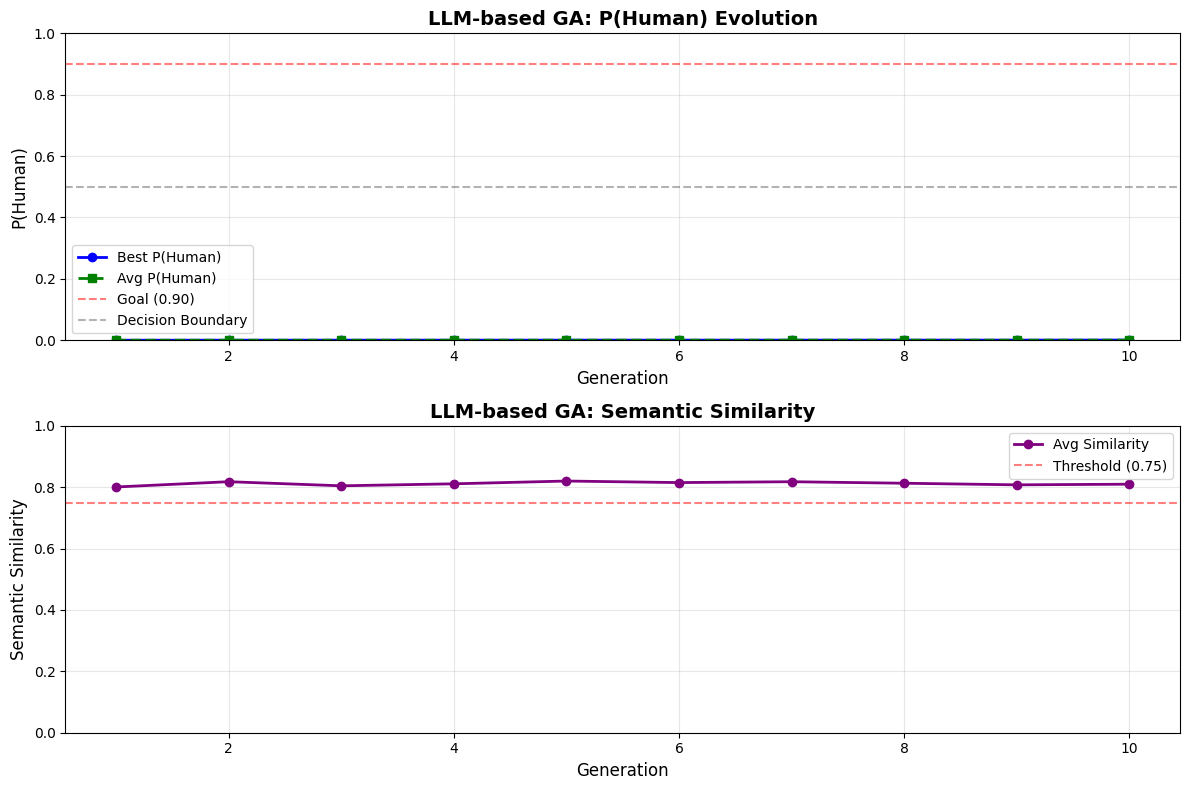


Visualization saved to llm_ga_evolution.png


In [27]:
# Cell 14: Visualize Evolution Progress
# Load data from CSV if history not available
if 'history' not in globals() or not history:
    print("Loading evolution data from CSV...")
    try:
        df = pd.read_csv(LLM_GA_CSV)
        
        # Aggregate by generation
        gen_stats = df.groupby('generation').agg({
            'fitness': ['max', 'mean'],
            'p_human': 'max',
            'semantic_similarity': 'mean'
        }).reset_index()
        
        gen_stats.columns = ['generation', 'best_fitness', 'avg_fitness', 'best_p_human', 'avg_similarity']
        
        history = [
            {
                'generation': int(row['generation']),
                'best_fitness': float(row['best_fitness']),
                'avg_fitness': float(row['avg_fitness']),
                'avg_similarity': float(row['avg_similarity'])
            }
            for _, row in gen_stats.iterrows()
        ]
        print(f"Loaded {len(history)} generations from CSV")
    except Exception as e:
        print(f"ERROR loading CSV: {e}")
        history = []

if not history:
    print("No evolution data available. Run Cell 13 first.")
else:
    # Create visualization
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    generations = [h['generation'] for h in history]
    best_fitnesses = [h['best_fitness'] for h in history]
    avg_fitnesses = [h['avg_fitness'] for h in history]
    
    # Plot 1: P(Human) over generations
    axes[0].plot(generations, best_fitnesses, 'b-o', label='Best P(Human)', linewidth=2)
    axes[0].plot(generations, avg_fitnesses, 'g--s', label='Avg P(Human)', linewidth=2)
    axes[0].axhline(y=0.90, color='r', linestyle='--', alpha=0.5, label='Goal (0.90)')
    axes[0].axhline(y=0.50, color='k', linestyle='--', alpha=0.3, label='Decision Boundary')
    axes[0].set_xlabel('Generation', fontsize=12)
    axes[0].set_ylabel('P(Human)', fontsize=12)
    axes[0].set_title('LLM-based GA: P(Human) Evolution', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim([0, 1])
    
    # Plot 2: Semantic similarity over generations
    similarities = [h['avg_similarity'] for h in history]
    axes[1].plot(generations, similarities, 'purple', marker='o', label='Avg Similarity', linewidth=2)
    axes[1].axhline(y=0.75, color='r', linestyle='--', alpha=0.5, label='Threshold (0.75)')
    axes[1].set_xlabel('Generation', fontsize=12)
    axes[1].set_ylabel('Semantic Similarity', fontsize=12)
    axes[1].set_title('LLM-based GA: Semantic Similarity', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim([0, 1])
    
    plt.tight_layout()
    plt.savefig('llm_ga_evolution.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nVisualization saved to llm_ga_evolution.png")